In [12]:
from src import cherry_blossom_utils as util
from src import prediction_utils as pred_util
from datetime import datetime as dt
import warnings
warnings.filterwarnings("ignore")

# Introduction

Given the ground-truth issue that we cannot accurately predict peak blooms more than 10-days in advance, we set our sights on expanding this range. To do this, we utilized over 245 unique features of the previous year's weather data to predict peak bloom. In essence, expanding from 10-days to potentially over two-months of advance notice (depending on the date of peak bloom).

# Data Preprocessing

The data provided by the event organizers will form the foundation of our training dataset. Some files – like Switzerland and Japan – are already in our ideal format. However, the USA-NPN dataset needs some additional formatting before it is usable.

Our target format for the data follows the following format. This example has been taken from the Japan dataset:

**[TODO -- INSERT TABLE HERE]**

In addition to the re-formatting of this file, we also need to isolate the data for NYC which is one of the locations included in the contest submission. Therefore, two dataframes will be created; one for NYC and another for all other locations in the US.

Once this processing is completed, we are left with the following:

In [2]:
# Load USA-NPN dataset
usa_npn = pd.read_csv("./data/raw/USA-NPN_status_intensity_observations_data.csv", na_values=[-9999.00])

# Get NYC-specific data
nyc_df = usa_npn[(usa_npn['Site_ID'] == 32789) & (usa_npn['Species_ID'] == 228)]
nyc_df = nyc_df[['Species_ID', 'Site_ID', 'Latitude', 'Longitude', 'Elevation_in_Meters', 'Observation_Date', 'Day_of_Year', 'Phenophase_Status']]

nyc_bloom_df = util.format_df(nyc_df)

nyc_bloom_df = nyc_bloom_df[['location', 'Latitude', 'Longitude', 'Elevation_in_Meters', 'Year', 'Observation_Date', 'Day_of_Year']]

nyc_bloom_df.columns = ['location', 'lat', 'long', 'alt', 'year', 'bloom_date', 'bloom_doy']

# Output the dataframe to CSV
nyc_bloom_df.to_csv("./data/interim/main_locations/validation/nyc.csv", index=False)

# Get USA data
usa_df = usa_npn[(usa_npn['Site_ID'] != 32789) | (usa_npn['Species_ID'] != 228)]
usa_df = usa_df[['Species_ID', 'Site_ID', 'Latitude', 'Longitude', 'Elevation_in_Meters', 'Observation_Date', 'Day_of_Year', 'Phenophase_Status']]

usa_bloom_df = util.format_df(usa_df)

usa_bloom_df = usa_bloom_df[['location', 'Latitude', 'Longitude', 'Elevation_in_Meters', 'Year', 'Observation_Date', 'Day_of_Year']]

usa_bloom_df.columns = ['location', 'lat', 'long', 'alt', 'year', 'bloom_date', 'bloom_doy']

# Output the dataframe to CSV
usa_bloom_df.to_csv("./data/raw/usa_formatted.csv", index=False)

**USA Dataframe**

In [3]:
usa_bloom_df.head()

,location,lat,long,alt,year,bloom_date,bloom_doy
0,2251,45.485600,-122.855499,63,2010,2010-02-27,58
1,1841,39.973316,-82.802826,275,2010,2010-04-04,94
2,8861,41.713570,-121.507545,1452,2013,2013-05-08,128
3,8861,41.713570,-121.507545,1452,2014,2014-05-01,121
4,8861,41.713570,-121.507545,1452,2015,2015-05-20,140


**NYC Dataframe**

In [4]:
nyc_bloom_df.head()

,location,lat,long,alt,year,bloom_date,bloom_doy
0,32789,40.73082,-73.99733,5,2019,2019-04-08,98
1,32789,40.73082,-73.99733,5,2021,2021-04-05,95
2,32789,40.73082,-73.99733,5,2022,2022-03-30,89
3,32789,40.73082,-73.99733,5,2023,2023-04-02,92


Now that the data has been formatted correctly, we can begin the analysis of our data.

# Representative Locations

Amongst the supplied datasets, there were data for numerous locations from all across Asia, Europe, and North America. While it would be ideal to have extensive background data from all locations, given the time constraints of this competition we instead will instead take a different approach. In order to emulate the geographical diversity of the dataset in as few locations as possible, we will identify so-called "Representative Locations" for which we will acquire extensive historical data.

The Representative Locations are selected using a KMeans clustering algorithm, which clusters all available locations based on their latitude and longitude. Once clustered, we designate the location with the most number of observations as that cluster's Representative Location. From this, we are able to preserve the geographical diversity of the dataset in as few locations as possible.

For consistency's sake, we keep a constant k-value of `k=5`, giving us five Representative Locations for each dataset. We do this to ensure that no one-place is overrepresented in the supplimental data, as the norm would be to dynamically calculate the k-value based on the elbow-curve method.

In [5]:
# For each file, find its representative locations
for location in util.location_dict:
    clusters, rep_locations, loc_data = util.get_representative_locations(util.location_dict[location], location)

    # Output the cluster data
    clusters.to_csv(f"{util.CLUSTERS_FOLDER}{location}_clusters.csv", index=False)

    # Output the representative location lists
    rep_locations.to_csv(f"{util.LOCATIONS_FOLDER}{location}_representative_locations.csv", index=False)

    # Ouput location-specific validation data
    for i in range(0, len(loc_data)):
        loc_data[i].to_csv(f"{util.VALIDATION_FOLDER}{location}_{i+1}.csv", index=False)

Plotted on a map, we see that our geographical spread is adequate:

[INSERT FOLIUM PLOT HERE]

# Historical Weather Data

Disparate sources for historical weather data cause a lot of issues when trying to create a cohesive dataset for multiple locations across multiple jurisdictions. Our search for a single data source brought us to [Visual Crossing](https://www.visualcrossing.com/) – a weather data and analytics firm – whose data spans the world-over and has ample coverage for our use-case.

In total, we gathered data for the above-mentioned Representative Locations, as well as the five locations included in the final prediction (NYC, Washington DC, Vancouver, Kyoto, and Liestal). When exploring the data offered by Visual Crossing, we identified the following candidate features as features for our training dataset along with the associated reasons:

- **Date time or Timestamp:** This is essential for establishing the temporal relationship between the environmental variables and the peak bloom.
- **Maximum temperature, Minimum temperature, Temperature:** Temperature plays a significant role in the blooming process of cherry blossoms. Both minimum and maximum temperatures can influence the timing of bloom.
- **Dew:** Dew can impact the moisture levels around the cherry blossom trees, which could affect their blooming.
- **Humidity:** Humidity levels can also influence the health and growth of cherry blossoms.
- **Precipitation amount, Precipitation probability, Precipitation type, Precipitation cover:** Precipitation, including its amount, probability, type, and coverage, can affect soil moisture and overall environmental conditions for cherry blossoms.
- **Wind speed, Wind direction, Wind gust:** Wind conditions can impact the dispersal of pollen and affect the health of cherry blossoms.
- **Pressure:** Atmospheric pressure can influence weather patterns, which in turn can affect cherry blossom growth.
- **Cloud cover:** Cloud cover affects the amount of sunlight reaching the cherry blossom trees, which can influence their growth and blooming.
- **Solar radiation, Solar energy, UV index:** These variables are related to sunlight exposure, which is essential for photosynthesis and the overall health of cherry blossom trees.

Our goal was to isolate the past 20-30 years of data from each dataset, so while not all of these data were available for the entire time period provided, it still provided us with what we needed. As such, our timeframe for these data queries were either `1990-01-01` to `2023-12-31` **OR** `2000-01-01` to `2023-12-31`.

In [6]:
for index in range(0, len(util.dir_paths)):
    # Process the raw data
    df_dict = util.process_weather_files(util.dir_paths[index])
    
    # Output the aggregated files
    for file_name in df_dict:
        df_dict[file_name].to_csv(f"{util.OUTPUT_PATHS[index]}{file_name}", index=False)

After acquiring the data, the last step was to standardize it by aggregating it by month and year. This process was relatively straigtforward and yielded the following results.

It is important to note that the integers next to the variable names represent months (i.e. _01 is January, _02 is February, etc.).

In [7]:
df_dict[file_name].head()

,location,year,tempmax_01,tempmax_02,tempmax_03,tempmax_04,tempmax_05,tempmax_06,tempmax_07,tempmax_08,...,day_length_03,day_length_04,day_length_05,day_length_06,day_length_07,day_length_08,day_length_09,day_length_10,day_length_11,day_length_12
0,"38.8853,-77.0386",1990,10.967742,12.432143,15.245161,19.246667,22.383871,28.860000,30.751613,28.596774,...,43078.612903,47639.000000,51494.967742,53448.133333,52488.193548,49126.870968,44772.666667,40234.258065,36247.633333,34173.451613
1,"38.8853,-77.0386",1991,7.567742,10.939286,13.719355,19.566667,27.732258,29.806667,31.935484,31.222581,...,43041.838710,47604.233333,51469.806452,53443.166667,52506.096774,49158.258065,44808.600000,40269.387097,36274.366667,34178.580645
2,"38.8853,-77.0386",1992,7.612903,9.441379,11.632258,17.906667,21.729032,26.723333,30.354839,27.400000,...,43157.258065,47712.500000,51547.354839,53456.033333,52447.258065,49057.806452,44695.266667,40159.612903,36192.466667,34164.838710
3,"38.8853,-77.0386",1993,7.838710,5.507143,9.519355,17.830000,24.764516,29.040000,33.035484,31.106452,...,43120.290323,47677.833333,51522.258065,53451.500000,52465.612903,49089.548387,44731.466667,40195.161290,36219.066667,34169.645161
4,"38.8853,-77.0386",1994,1.948387,6.750000,12.145161,22.250000,22.790323,31.390000,31.967742,28.403226,...,43083.548387,47642.833333,51497.129032,53446.733333,52483.967742,49121.451613,44767.700000,40230.290323,36245.866667,34174.645161


# Creating the Training Dataset

After standardizing the format of all our raw data files, we then sought to create a single dataset with all training examples.

Since all of the files are in a consistent format, we can now combine them all with ease. The final dataset contains 267 observations from 21 different locations across the globe.

**Missing Values**

To address gaps in the data we employed the use of dataset-means to fill in missing values. This allowed us to have a more complete dataset.

**Outliers**

Our tests indicated that the removal of outliers hurt our model (R2 decreased by ~0.3). As such, we opted to leave them in in favor of a more diverse training dataset.

In [8]:
combined_df = pd.DataFrame()

for index in range(0, len(util.VALIDATION_PATHS)):
    # Process the raw data
    df_dict = util.combine_files(util.VALIDATION_PATHS[index], util.CLEANED_PATHS[index])
    
    # Output the aggregated files
    for file_name in df_dict:
        df_dict[file_name].to_csv(f"{util.INDIV_OUT_PATH}{file_name}", index=False)
        
        combined_df = pd.concat([combined_df, df_dict[file_name]], ignore_index=True)

combined_df = combined_df.reset_index(drop=True)

# To handle missing values, use the mean of each feature
combined_df = combined_df.fillna(combined_df.mean(numeric_only=True))

combined_df.to_csv(f"{util.COMBINED_OUT_PATH}combined.csv", index=False)

[TODO -- insert a table here with the number of observations at each location]

# Constructing the Model

We intially reviewed four candidate models for this prediction task: SVR, Linear Regression, Random Forest Regression, and Gradient Boost Regression. Following an analysis of each model's performance with the data we sourced, it was decided that we would use a **Gradient Boost Regression (GBR)** model.

With the candidate model selected, we then moved on to the final two tasks: feature extraction and HPO.

**Feature Extraction**

We used Cumulative Feature Importance with a threshold of `0.90` to conduct our feature extraction. This process narrowed our feature space from ~245 features down to 34 features (see figure below).

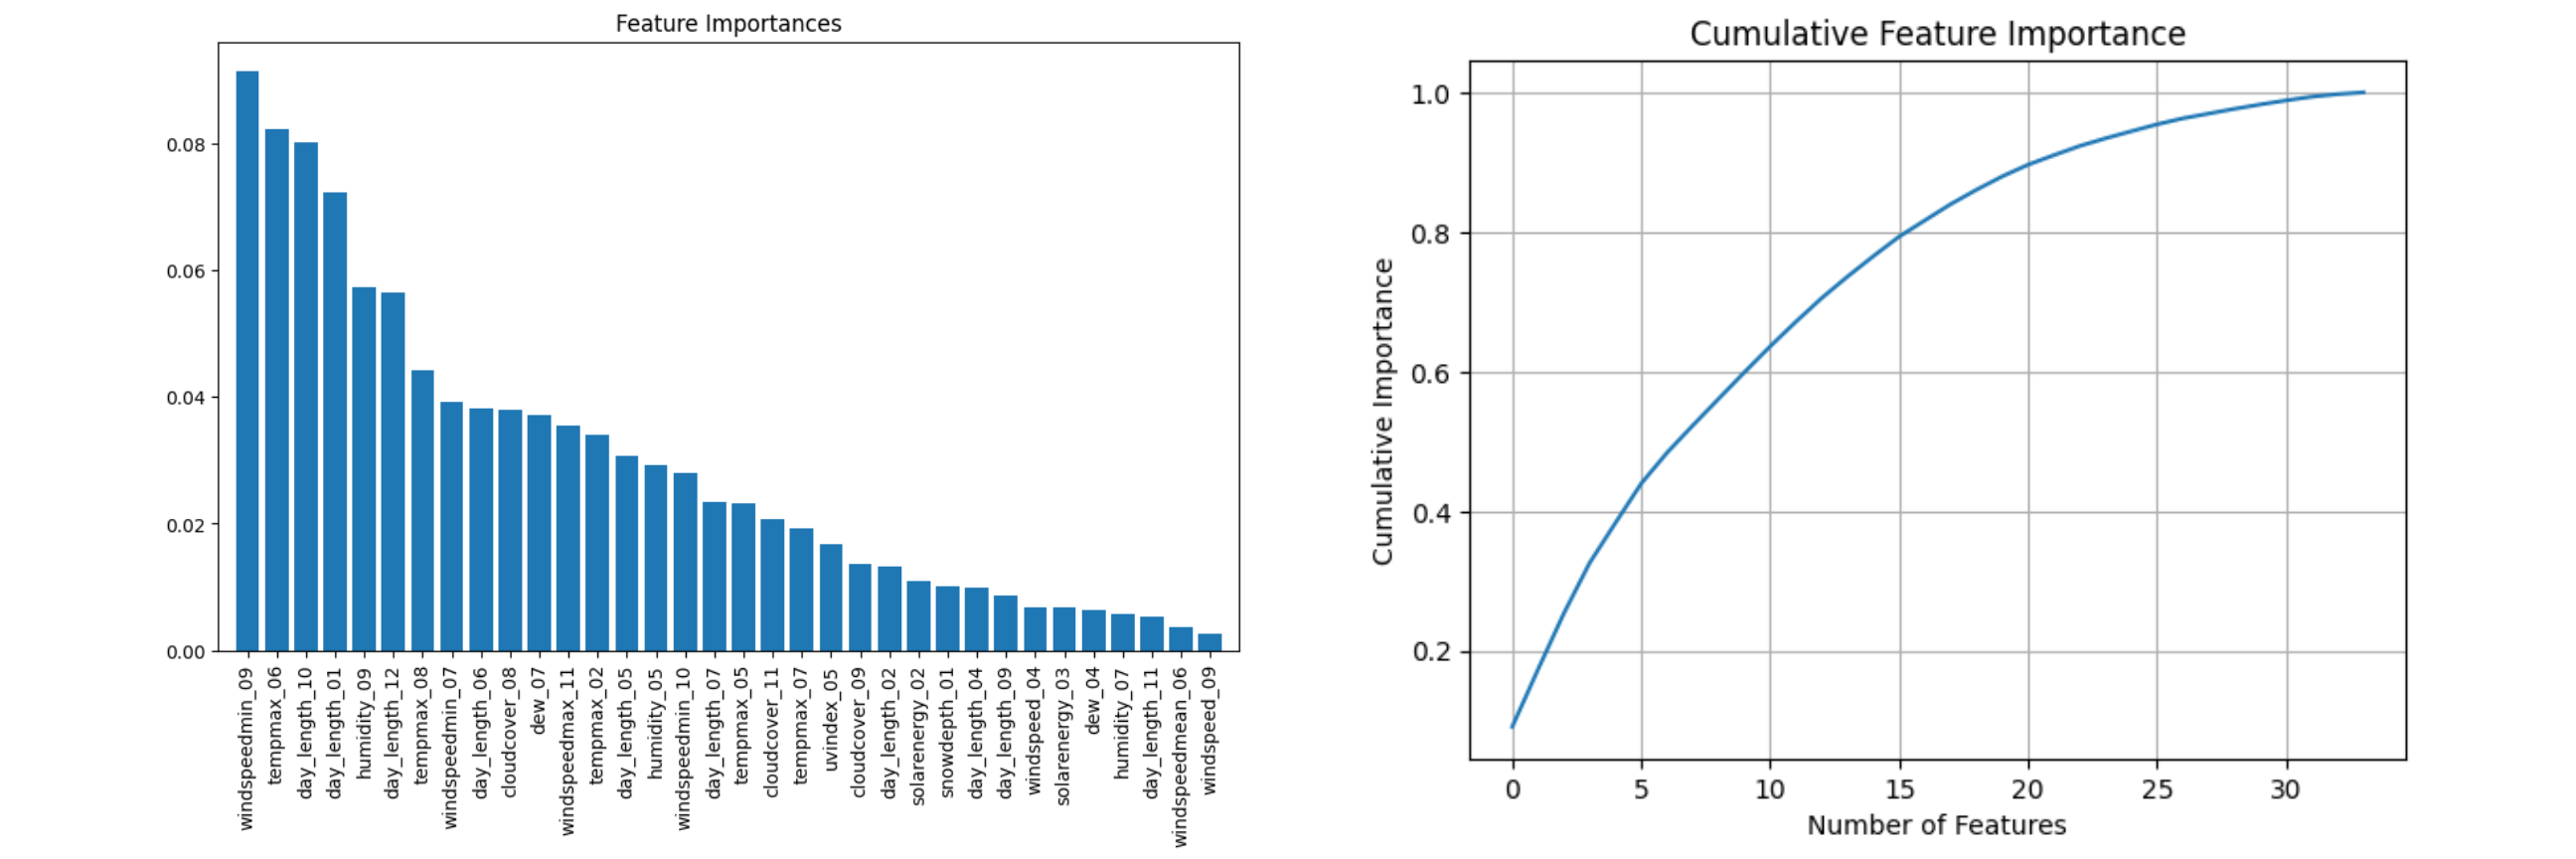

**Hyper Parameter Optimization (HPO)**

We used the `scikit-learn::GridSearchCV` to perform our HPO. Our initial configuration space had approximately 6,720 unique combinations and each iteration was scored based on it's R2 value.

**Model Performance**

The optimal version of tht GBR model we created produced the following R2 and MSE:

In [9]:
# Load combined data
data = pd.read_csv("./data/cleaned/combined.csv")

# Remove metadata columns
data = data.drop(columns=['location', 'lat', 'long', 'alt', 'year', 'bloom_date'])

# Split features (X) and target variable (y)
X = data.drop(columns=['bloom_doy'])
y = data['bloom_doy']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = pred_util.train_test_split(X, y, test_size=0.2, random_state=42)

# Subset the data based on the selected features
X_train_scaled = pred_util.scaler.fit_transform(X_train[pred_util.selected_features])
X_test_scaled = pred_util.scaler.transform(X_test[pred_util.selected_features])

# Capture scaling parameters using the X_train dataframe
# Subset it by taking the selected_features
normalization_params = pred_util.compute_normalization_params(X_train[pred_util.selected_features])

# Initialize and train the Gradient Boosting Regressor
model = pred_util.GradientBoostingRegressor(**pred_util.best_params)
model.fit(X_train_scaled, y_train)

# Make predictions and cast from float to integer
y_pred_int = pred_util.get_predictions(X_test_scaled, model)

# Model evaluation (MSE and R2)
pred_util.evaluate_model(y_test, y_pred_int) # THIS PRINTS MSE and R2

# NOTE: THIS MODEL HAS ALREADY BEEN CREATED AND SAVED, SO THAT PART OF THE CODE HAS BEEN
#       LEFT OUT. IF YOU ARE INTERESTED IN SEEING THAT PORTION OF THE CODE,
#       PLEASE LOOK THROUGH "./notebooks/4-ConstructModel.ipynb".

Mean Squared Error: 68.61111111111111
R-squared: 0.8498671789407333


# Final Model Predictions

In [10]:
# Load new data here
file_path = "./data/inputs/competition_input.csv"

input_df = pd.read_csv(file_path)
input_df = input_df[pred_util.feature_list]

# Normalize data
input_df = pred_util.normalize_new_data(input_df, pred_util.normalization_params)

predictions, lower_bound, upper_bound = pred_util.get_final_predictions(input_df, pred_util.model)

predictions_df = pd.read_csv(file_path)[['location']]
predictions_df["prediction"] = predictions
predictions_df["lower"] = lower_bound
predictions_df["upper"] = upper_bound

predictions_df = predictions_df[['location', 'prediction', 'lower', 'upper']]

# Create an output filename using the current timestamp
output_file_name = f"./data/output/{dt.now().strftime('%Y-%m-%d_%H-%M-%S') + '.csv'}"

# Output the dataframe
predictions_df.to_csv(output_file_name, index=False)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


In [11]:
predictions_df

,location,prediction,lower,upper
0,washingtondc,84,81,86
1,liestal,80,77,82
2,kyoto,96,94,98
3,vancouver,100,97,102
4,nyc,92,90,95
